### Zillow Clustering Project

#### Corey Solitaire - Oct. 21st 2020

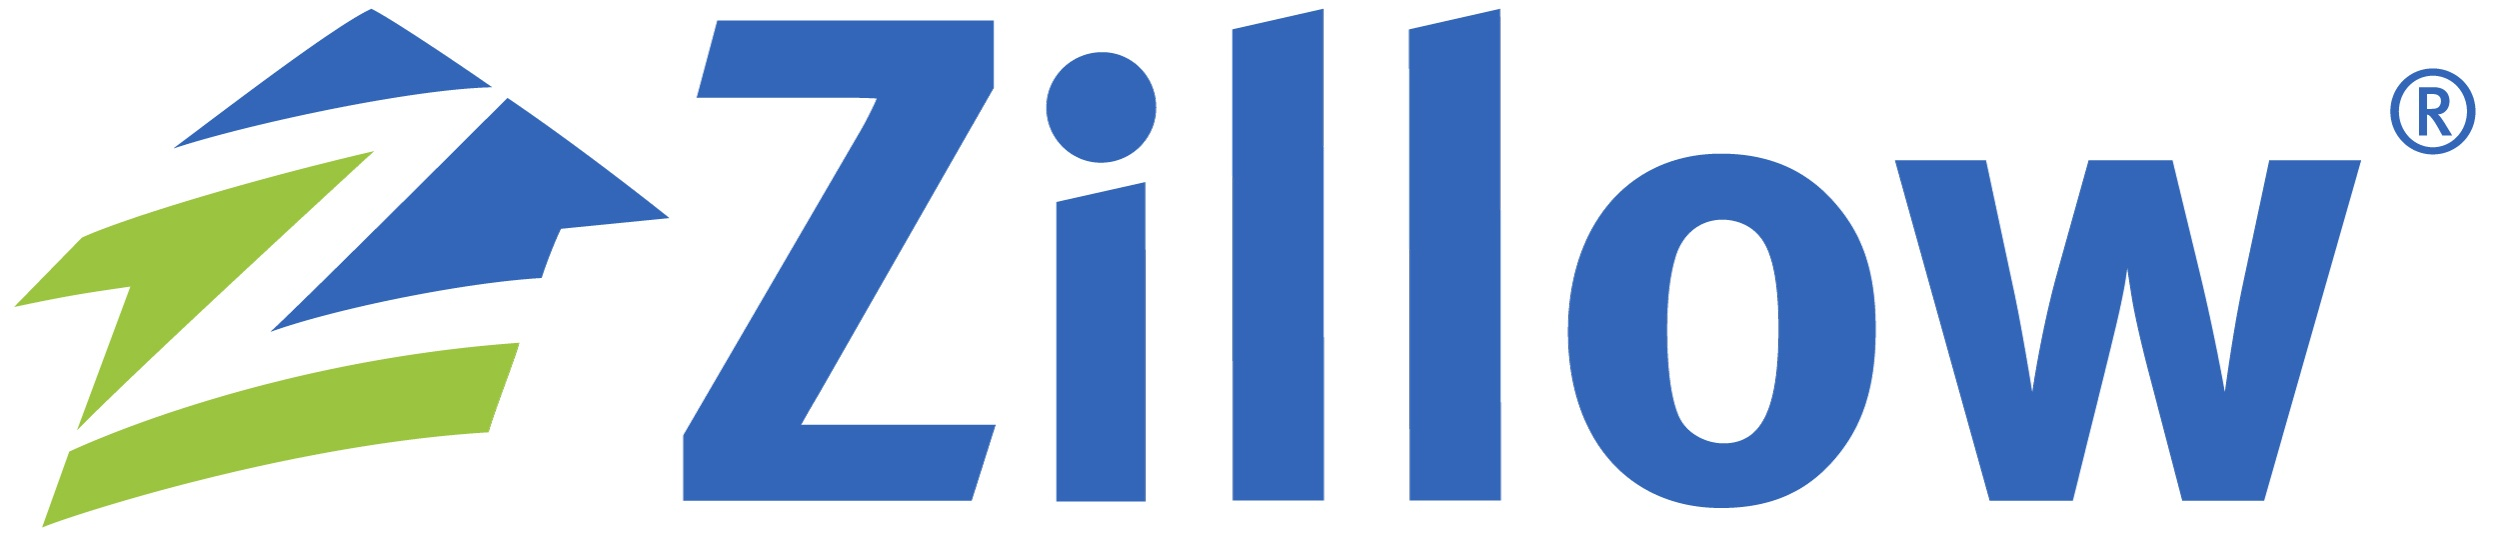

<div class="alert alert-block alert-info"><b></b></div>

# Executive Summary:

***

**Project Summary:**   
*The purpose to this project was to access single unit properties sold in 2007, combine features of those properties in to clusters (feature engeneering) and then develop models based on those features that would best predict logerror (log(Zestimate)−log(SalePrice)).*

**Background:**   
*The Zillow dataset (a competition dataset from Kaggle) consists of information on 2.9 million real estate properties in three counties (Los Angeles, Orange and Ventura, California) sold between October 2016 to December 2017. This project foucuses on the LA County dataset, the largest and most complex of the three.*  

**Process:**   
*3 clusters (room, size, location) were created using the training dataset and 5 of these engeneered features were utilized to build a predictive linear model.  Baseline was estabolished using the mean of the y-train based on the distribution of the data.  Out of several regression model the linear regression model preformed best on train and validate data sets, however it failed to beat baseline on the test data set.*   

**Results and Conclusions:**   
*Modeling produced an average RMSE of 0.17%, however that error represents a -6.87% improvement over baseline.  Model accuracy did not significantly change over train, validate, test suggesting a need for further feature engeneering (cluster design) or different modeling techniques.  There exists the possibility that regression models may not be the best tool to predict logerror in this dataset.*

**Reccomendations:**   
1. *Too Much Data?:Investigate impact of further reducing outliers with regards to logerror.* 

2. *Best Features?: reexamine features to produce new clusters that are better able to predict logerror.*

4. *New Model?: Regression models might not the best approch to predict logerror.*

4. *Other Counties?: This model may work better on other CA counties, further investigation is necessary.* 

<div class="alert alert-block alert-info"><b></b></div>

 # Planning:
 
 ***

# Goals:

#### *1. Explore features of Zillow data set and create 3 clusters that are statistically significant in their relationship to logerror.*   

#### *2. Create features from data clusters (or cluster centers as centroids) and use them to train a regressio model to predict logerror.*

#### *3. Determine the drivers of logerror in Zillows Zestimate*

#### *4. Develop and deliver a professional jupyter notebook outlineing your experience and familiarity with the process of data clustering, module creation, and technical delivery.*


***

# Audience:

#### *- Data science team*

***

# Work Flow:

#### 1. Data Acquistion
    - SQL Database
    - wrangle.py
#### 2. Data Preparation
    - wrangle.py
#### 3. Data Exploration
    - Visulaizations
    - Hypothesis testing
    - Cluster creation
        - explore.py
#### 4. Modeling
    - Regression Models
        - explore.py
#### 5. Conclusions
    - Claim, Evidence, Reasoning
#### 6. Next Steps
    - The goood, the bad, the ugly
    - Tips for improvement

***

<div class="alert alert-block alert-info"><b></b></div>

### Imports:

In [5]:
import wrangle
import explore
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:20,.2f}'.format

from math import sqrt
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler, QuantileTransformer, PowerTransformer, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression, SelectKBest, RFE 
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans

<div class="alert alert-block alert-info"><b></b></div>

# Data Acquisition:

### SQL Querry

In [ ]:
sql_query = '''
                select prop.parcelid
                , pred.logerror
                , bathroomcnt
                , bedroomcnt
                , calculatedfinishedsquarefeet
                , fips
                , latitude
                , longitude
                , lotsizesquarefeet
                , regionidcity
                , regionidcounty
                , regionidzip
                , yearbuilt
                , structuretaxvaluedollarcnt
                , taxvaluedollarcnt
                , landtaxvaluedollarcnt
                , taxamount
            from properties_2017 prop
            inner join predictions_2017 pred on prop.parcelid = pred.parcelid
            where propertylandusetypeid = 261;
                '''

### Explanation

*Following the walkthrough I class I modified my SQL querry to match.  In previous attemps to build predictive models on the Zillow data trying to determine single unit properties was a real concern.  By focusing on a single property land luse type (261) I was able to focus my search on properties that are defined as single units, thus providing me with better data for exploration and modeling.  This querry also focuses on properties of the Zillow data set that are largely numeric and intact.  Being more selective on the import from SQL saved me time and energy and allowed me to focus on my goal of cluster creation and predictive modeling.*  

### Import Modlue (wrangle.py)

- **def get_connection()** 
    - This function uses an env file to estabolish a connection url to access the Codeup db.
- **def new_zillow_data()**
    - This function reads the Zillow customer data from the Codeup db into a df, write to csv, and returns df.
- **def get_zillow_data()**
    - This function reads the Zillow data from the csv and returns a df

<div class="alert alert-block alert-info"><b></b></div>

# Data Preparation:

### Clean Data (wrangle.py)

In [7]:
def clean_zillow_data(df): 
    df.latitude = df.latitude / 1000000
    df.longitude = df.longitude / 1000000
    df = get_counties(df)
    df = create_features(df)
    df = remove_outliers(df)
    df = col_to_drop_post_feature_creation(df)
    mask = df['bed_bath_ratio'] != np.inf
    df.loc[~mask, 'bed_bath_ratio'] = df.loc[mask, 'bed_bath_ratio'].max()
    df.dropna(inplace=True)
    df_la, df_v, df_o = county_df(df)
    return df_la, df_v, df_o

### Explanation  

The function **clean_zillow_data()** takes care of all the cleaning I needed to do in my dataset.  First it devides latitude and longitude by 1000000 to express them in units that can be mapped.  Scaling these numbers also narrows range in the variable and makes it better for modeling. It also drops all missing values after data cleaning and returns 3 dataframes (specific to county).    

The function **get_counties()** takes the dataframe and create a new column called 'county' that uses the fips data to encode county ID as LA, Ventura, or Orange.  

The function **create_features()** creates new features from existing data.  The new features created include **age** calculated by subtracting 2017 - 'yearbuilt', **taxrate** calculated by diviging 'taxamount'/'taxvaluedollarcnt', **acres** caluclated by dividing 'lotsizesquarefeet' / 43560, **structure_dollar_per_square_foot** by dividing 'structurevaluetaxdollarcnt' / 'calculatedfinishedsquarefeet', **land_dollar_per_square_foot** by dividing 'taxvaluedolarcnt' / 'lotsizesquarefeet', and finally **bed_bath_ratio** by dividing 'bedroomcnt' / 'bathroomcnt'.  

The function **remove_outliers()** remove extreme outliers in a variety of features.  First it limits the returned data frame to properties with 1 - 7 baths, and 1 - 7 bedrooms. It then corrects the error in zip, removing properties where the zip codes that are greather then 6 numbers.  It removes properties with square feet > 7000, removes lot sizes (acres) > 10, and finally it removes properties where the tax rate is > 5% (6% is national average).    

The function **col_to_drop_post_feature_creation()** drops colums used to create new features.  Specifically it drops 'bedroomcnt', 'taxamount','taxvaluedollarcnt', 'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt','lotsizesquarefeet', "regionidzip", "yearbuilt",'parcelid','regionidcity'.  There colums are not longer necessary because the engeneerd featurs now represent the information they hold in a way that reduces collinearity. 

The function **county_df()** takes the cleaned data and breaks it in to three dataframes, one for each of the counties reprsented in the Zillow data set.  Previous investigations and hypothesis tests indicated a signficant difference in logerror between counties and these individual datasets provide a means to examine the drivers of logerror in isolation.  
***

In [ ]:
# Data Exploration:

### How to best Model Logerror?
### Hypothesis Test: Counties
    - Visualize
    - Test
### Results: 3 Data Frames (LA, Ventura, Orange)
    - Call Function
### LA County - (Greatest # of Homes, Greatest Variety of Homes) 
    - Visualize
### Cluster Selection (3)
    - Explaination
    - Visualize
    - Hypothesis Test

In [ ]:
# Modeling:

### Determine Baseline
    -Visualize
    -Explain
    
### 1st Iteration
    -Model
    -Result
    -Conclusion

In [ ]:
# Conclusions:
    -Summary of Findings

In [ ]:
# Next Steps: 
    - Summy of What Next